In [1]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # For displaying images in Colab

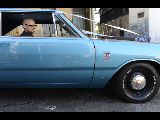

In [2]:
# Specify the path to your image file
image_path = '/content/raw.NEF'

# Load the image using OpenCV
image = cv2.imread(image_path)

# Display the image
cv2_imshow(image)

# # Display the image         (NOT DISPLAYING PROPER COLOURINGS)
# plt.imshow(image)
# plt.axis('off')  # Turn off axis labels
# plt.show()

In [3]:
#Checking the image parameters
print(image)
print(image.shape)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(120, 160, 3)


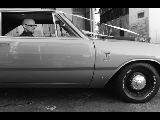

(120, 160)


In [4]:
#Convert image to Gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

original_im_shape=gray_image.shape
cv2_imshow(gray_image)
print(original_im_shape)

In [5]:
print(gray_image)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Forward transform coding

---



In [6]:
dct_result = cv2.dct(np.float32(gray_image))
# print(dct_result)

### Spliting image into macro blocks with size of 8*8
---




In [7]:
def split_into_blocks(matrix, block_size=8):
    rows, cols = matrix.shape
    block_matrices = []

    for row in range(0, rows, block_size):
        for col in range(0, cols, block_size):
            block = matrix[row:row+block_size, col:col+block_size]
            block_matrices.append(block)

    return block_matrices

In [8]:
# Split the large matrix into 8x8 macro blocks
blocks = split_into_blocks(dct_result, block_size=8)
print(blocks[0]) #217136.

[[11809.705    -1663.8281      98.283714 -1005.9242     718.7467
   -411.43076    -27.713182   228.3384  ]
 [ 3831.5208    -610.2675      48.417473  -817.22614    612.86304
   -340.31488     49.245827  -116.239586]
 [-4033.5474     -82.32722    629.1125    -717.0674     444.06506
    -48.744595   -38.5658      40.62728 ]
 [-3926.6465     393.0324      37.265503    46.755157    42.31813
    391.20078   -230.29633    240.68874 ]
 [ -351.53253    421.0302    -425.2152     797.2213    -315.4125
    328.891      235.31198   -254.77292 ]
 [  644.4569      25.410686   425.23532    306.66006   -179.55338
    219.77817     70.64167    -27.482357]
 [-1130.4298    1090.7527      97.45506    247.98824   -255.86525
     86.081764  -104.65991    351.8792  ]
 [ -756.2214    1271.5918    -353.12036    393.16617   -279.32645
   -390.97903    370.54584   -110.93729 ]]


In [9]:

# print("\n8x8 Macro Blocks:")
# for block in blocks:
#     print(block)
#     print()


# Quantizing

---



In [10]:
def quantize(block, quality):
    # Quality levels for JPEG (Q50, Q70, Q90)
    quality_factors = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    if quality < 40:
        scale = 40 / quality
        quality_level = "Low Quality"
    elif 40 <= quality <= 70:
        scale = 2 - quality / 70
        quality_level = "Medium Quality"
    else:
        scale = 100 / quality
        quality_level = "High Quality"

    quantized_block = np.round(block / ((quality_factors-50)* scale))

    return quantized_block, quality_level

def dequantize(quantized_block, quality):
    # Quality levels for JPEG (Q50, Q70, Q90)
    quality_factors = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    if quality < 40:
        scale = 40 / quality
    elif 40 <= quality <= 70:
        scale = 2 - quality / 70
    else:
        scale = 100 / quality

    return quantized_block * ((quality_factors-50) * scale)


In [11]:
# Quantize the DCT coefficients at different quality levels
quantized_dct_high, quality_level_high = quantize(blocks, 100)

print(quantized_dct_high[0:2])
# print(type(quantized_dct_high[0][0][0]))

[[[-3.47e+02  4.30e+01 -2.00e+00  3.00e+01 -2.80e+01  4.10e+01 -2.80e+01
    2.10e+01]
  [-1.01e+02  1.60e+01 -1.00e+00  2.60e+01 -2.60e+01 -4.30e+01  5.00e+00
   -2.30e+01]
  [ 1.12e+02  2.00e+00 -1.90e+01  2.80e+01 -4.40e+01 -7.00e+00 -2.00e+00
    7.00e+00]
  [ 1.09e+02 -1.20e+01 -1.00e+00 -2.00e+00  4.20e+01  1.10e+01 -8.00e+00
    2.00e+01]
  [ 1.10e+01 -1.50e+01  3.30e+01  1.33e+02 -1.80e+01  6.00e+00  4.00e+00
   -9.00e+00]
  [-2.50e+01 -2.00e+00  8.50e+01  2.20e+01 -6.00e+00  4.00e+00  1.00e+00
   -1.00e+00]
  [ 1.13e+03  7.80e+01  3.00e+00  7.00e+00 -5.00e+00  1.00e+00 -1.00e+00
    7.00e+00]
  [-3.40e+01  3.00e+01 -8.00e+00  8.00e+00 -5.00e+00 -8.00e+00  7.00e+00
   -2.00e+00]]

 [[ 1.00e+01  2.00e+00 -1.00e+01  7.00e+00 -3.00e+00  8.00e+00  2.47e+02
   -3.00e+01]
  [ 3.00e+00  6.00e+00 -1.80e+01  5.00e+00  4.00e+00  2.00e+01  9.00e+00
   -2.60e+01]
  [ 5.00e+00  0.00e+00 -1.30e+01  2.00e+00  2.00e+00  3.20e+01  4.00e+00
   -8.00e+00]
  [ 1.30e+01 -1.30e+01 -3.00e+00 -5.00e+0

# Entropy encoding

---



In [12]:
import heapq
from collections import defaultdict

def calculate_frequencies(arr):
    frequencies = defaultdict(int)
    for row in arr:
        for col in row:
            for value in col:
                frequencies[value] += 1
    return frequencies

def build_huffman_tree(frequencies):
    heap = [[weight, [value, ""]] for value, weight in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return heap[0][1:]

def generate_huffman_code(tree):
    huffman_code = {}
    for value, code in tree:
        huffman_code[value] = code
    return huffman_code

def huffman_encode(arr, huffman_code):
    encoded_arr = [[[huffman_code[value] for value in col] for col in row] for row in arr]
    return encoded_arr

def huffman_decode(encoded_arr, huffman_code):
    decoding_dict = {code: value for value, code in huffman_code.items()}
    decoded_arr = [[[decoding_dict[code] for code in col] for col in row] for row in encoded_arr]
    return decoded_arr

# Input array
# input_arr = [[[1.3571e+04, 3.0750e+03, -9.5760e+03, -1.2960e+03, -2.1740e+03, 4.2000e+01, 3.3500e+02, -1.6800e+02],
#               [1.2410e+03, 2.4580e+03, 1.9810e+03, -0.0000e+00, -1.0230e+03, -4.3100e+02, -1.4100e+02, -1.5500e+02],
#               # ... (remaining rows)
#              ]]

input_arr=quantized_dct_high

# Calculate frequencies
frequencies = calculate_frequencies(input_arr)

# Build Huffman tree
huffman_tree = build_huffman_tree(frequencies)

# Generate Huffman code
huffman_code = generate_huffman_code(huffman_tree)

# Huffman encode the input array
encoded_arr = huffman_encode(input_arr, huffman_code)

# # Huffman decode the encoded array
# decoded_arr = huffman_decode(encoded_arr, huffman_code)

# Display the results
# print("Huffman Code:", huffman_code)
print("Encoded Array:", encoded_arr[0:8])
print(type(encoded_arr[0]))
# print("Decoded Array:", decoded_arr)
print(huffman_code)


Encoded Array: [[['00100110000001', '001010010100', '00111', '00011000010', '00100111010', '0010100100111', '00100111010', '00110011110'], ['00100110010000', '0010001101', '011', '00110011111', '00110011000', '000111000110', '0001111', '0001100100'], ['00101001110010', '0000', '0001100101', '0001100000', '0010011011000', '00101000', '00111', '00110001'], ['00101001110001', '001001000', '011', '00111', '001000110000', '001001010', '00100001', '0010000010'], ['001001010', '0010101000', '00011000011', '00101001110101', '0010011110', '00101011', '0011011', '00011101'], ['00110011001', '00111', '00101001101100', '0010000011', '00110010', '0011011', '010', '011'], ['00101001111111', '00101001101010', '001011', '00110001', '0001101', '010', '011', '00110001'], ['001001110001', '00011000010', '00100001', '00100010', '0001101', '00100001', '00110001', '00111']], [['001010101', '0000', '001001001', '00110001', '00010', '00100010', '00101001111010', '00100110110111'], ['001011', '00101011', '0010

In [13]:
def calculate_total_bits(encoded_arr):
    total_bits = 0
    for row in encoded_arr:
        for col in row:
            for code in col:
                total_bits += len(code)
    return total_bits

# Calculate total bits for the encoded array
total_bits = calculate_total_bits(encoded_arr)

# Display the result
print("Total Bits:", total_bits)

file_size=total_bits/1024
print(file_size,"kB")

Total Bits: 50271
49.0927734375 kB


In [14]:
def write_encoded_data_to_file(encoded_arr, output_file_path):
    with open(output_file_path, 'w') as file:
        for row in encoded_arr:
            for col in row:
                for code in col:
                    file.write(code)

# Example usage
output_file_path = 'encoded_data.txt'
write_encoded_data_to_file(encoded_arr, output_file_path)

In [15]:


def write_list_to_bin(data_list, output_path):
    # Open the binary file in write mode
    with open(output_path, 'wb') as bin_file:
        # Serialize and write the list to the binary file
        pickle.dump(data_list, bin_file)

# def read_list_from_bin(input_path):
#     # Open the binary file in read mode
#     with open(input_path, 'rb') as bin_file:
#         # Deserialize and read the list from the binary file
#         data_list = pickle.load(bin_file)

#     return data_list

# Example usage
# my_list = [[['0101111011010000100', '0101001010111001111', '01011110110100001010', '01011110111011000000', '01011110110100001101', '010101110111110', '0101001010101101001', '0101111011110010110'], ['0101001010111001000', '0101001010111001110', '0101001010111001100', '1', '01011110111011000010', '0101111011101101101', '010101111101110111', '0101111011110011100'], ['0101001010101001110', '0101001010111001010', '01011110110100001110', '0101100011011101', '0101001010111001101', '010100101010011000', '01011110111011111011', '01011110111011100001'], ['0101001010111001011', '0101111011101110001', '01011110111011010011', '0101001010101110010', '0101001010101010000', '010100101010011011', '0101100010000101', '01010111010000010']]]
bin_file_path = 'my_list.bin'

# Write the list to a binary file
write_list_to_bin(encoded_arr, bin_file_path)

# # Read the list from the binary file
# read_list = read_list_from_bin(bin_file_path)

# print("Original List:", my_list)
# print("Read List:", read_list)



# ***IMAGE*** ***RECONSTRUCTION***

---


In [16]:
def read_list_from_bin(input_path):
    # Open the binary file in read mode
    with open(input_path, 'rb') as bin_file:
        # Deserialize and read the list from the binary file
        data_list = pickle.load(bin_file)

    return data_list

 # Read the list from the binary file
read_list = read_list_from_bin(bin_file_path)
# print(read_list)

# Entropy decoding

---



In [17]:
# Huffman decode the encoded array
# decoded_arr = huffman_decode(encoded_arr , huffman_code)
decoded_arr = huffman_decode(read_list  , huffman_code)
print(decoded_arr)

[[[-347.0, 43.0, -2.0, 30.0, -28.0, 41.0, -28.0, 21.0], [-101.0, 16.0, -1.0, 26.0, -26.0, -43.0, 5.0, -23.0], [112.0, 2.0, -19.0, 28.0, -44.0, -7.0, -2.0, 7.0], [109.0, -12.0, -1.0, -2.0, 42.0, 11.0, -8.0, 20.0], [11.0, -15.0, 33.0, 133.0, -18.0, 6.0, 4.0, -9.0], [-25.0, -2.0, 85.0, 22.0, -6.0, 4.0, 1.0, -1.0], [1130.0, 78.0, 3.0, 7.0, -5.0, 1.0, -1.0, 7.0], [-34.0, 30.0, -8.0, 8.0, -5.0, -8.0, 7.0, -2.0]], [[10.0, 2.0, -10.0, 7.0, -3.0, 8.0, 247.0, -30.0], [3.0, 6.0, -18.0, 5.0, 4.0, 20.0, 9.0, -26.0], [5.0, 0.0, -13.0, 2.0, 2.0, 32.0, 4.0, -8.0], [13.0, -13.0, -3.0, -5.0, 56.0, -1.0, 7.0, -14.0], [-2.0, -2.0, 11.0, 30.0, -7.0, 0.0, -2.0, 7.0], [-4.0, 8.0, -46.0, 1.0, -4.0, -3.0, -2.0, 5.0], [191.0, 10.0, -17.0, -1.0, 0.0, -5.0, -1.0, 1.0], [17.0, -4.0, -9.0, -1.0, 0.0, -4.0, -4.0, 6.0]], [[-7.0, -9.0, 2.0, -1.0, -4.0, -6.0, -144.0, 28.0], [1.0, -17.0, 8.0, -3.0, -8.0, -4.0, -6.0, 45.0], [3.0, -9.0, 6.0, -1.0, -12.0, -8.0, -1.0, 4.0], [-2.0, 8.0, -2.0, 2.0, -53.0, 2.0, -2.0, 0.0], [8.

# Dequantizing

---



In [18]:
dequantized_blocks=[]
for blocks in decoded_arr:
    # Filter out None values
  filtered_array = np.where(blocks != None, blocks, np.nan)

  # Convert the filtered array to a numeric type (float)
  filtered_array = filtered_array.astype(np.float32)
  dequantized_block=dequantize(filtered_array, 100)
  dequantized_blocks.append(dequantized_block)
print(dequantized_blocks[0:2])


[array([[11798., -1677.,    80., -1020.,   728.,  -410.,   -28.,   231.],
       [ 3838.,  -608.,    36.,  -806.,   624.,  -344.,    50.,  -115.],
       [-4032.,   -74.,   646.,  -728.,   440.,   -49.,   -38.,    42.],
       [-3924.,   396.,    28.,    42.,    42.,   407.,  -240.,   240.],
       [ -352.,   420.,  -429.,   798.,  -324.,   354.,   212.,  -243.],
       [  650.,    30.,   425.,   308.,  -186.,   216.,    63.,   -42.],
       [-1130.,  1092.,    84.,   259.,  -265.,    71.,   -70.,   357.],
       [ -748.,  1260.,  -360.,   384.,  -310.,  -400.,   371.,   -98.]]), array([[-340.,  -78.,  400., -238.,   78.,  -80.,  247., -330.],
       [-114., -228.,  648., -155.,  -96.,  160.,   90., -130.],
       [-180.,   -0.,  442.,  -52.,  -20.,  224.,   76.,  -48.],
       [-468.,  429.,   84.,  105.,   56.,  -37.,  210., -168.],
       [  64.,   56., -143.,  180., -126.,    0., -106.,  189.],
       [ 104., -120., -230.,   14., -124., -162., -126.,  210.],
       [-191.,  140., -

# Inverse DCT

---



In [19]:
#-------------------------Combining macro blocks-------------------------------------#
def reconstruct_image(blocks, image_shape):
    rows, cols = image_shape
    block_size = blocks[0].shape[0]
    reconstructed_image = np.zeros((rows, cols), dtype=np.float32)

    block_index = 0
    for row in range(0, rows, block_size):
        for col in range(0, cols, block_size):
            reconstructed_image[row:row+block_size, col:col+block_size] = blocks[block_index]
            block_index += 1

    return reconstructed_image


In [20]:

merged_img=reconstruct_image(dequantized_blocks, original_im_shape)
print(merged_img)

[[ 1.1798e+04 -1.6770e+03  8.0000e+01 ... -1.0000e+01  3.2000e+01
  -2.2000e+01]
 [ 3.8380e+03 -6.0800e+02  3.6000e+01 ... -1.6000e+01  0.0000e+00
  -2.0000e+01]
 [-4.0320e+03 -7.4000e+01  6.4600e+02 ... -7.0000e+00  0.0000e+00
   1.8000e+01]
 ...
 [ 2.6000e+01 -3.0000e+01 -1.5000e+01 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.1200e+02 -4.2000e+01 -2.8000e+01 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [-4.4000e+01 -4.2000e+01 -4.5000e+01 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]


In [21]:
inverse_dct_result = cv2.idct(np.float32(merged_img))
print(inverse_dct_result[0:3])

[[-12.097965    12.641829     1.7290926   -6.271986    -2.487135
    0.65500355  -4.9718304    3.4326973    5.614373    -0.16108513
   -0.27980804   7.9825745    5.7212105    9.644203    24.157633
   -6.2067394    6.5512238   10.190407     2.6764145   12.226135
   -9.090139    -2.5431156  -20.056797    -1.1123123  -11.730459
    6.5577106   -9.208185     8.445678     3.8954544    1.4313126
    2.913807    -1.0788307    3.1739063   13.602211     0.6390648
   -8.240131     0.94425964  -3.1345177   15.904982    -0.8289108
    5.8426514   -7.4170914   -8.789349    -6.064926     2.3256989
   -4.5268555   -3.235546     1.3430805   10.359484     7.6551933
   10.536095     0.703598   -13.067436   -13.76026      4.027094
    5.305811    -5.9862757   33.247124     4.7363434    1.2953873
  -18.02575      8.913986    10.6633835   12.871649   -15.462231
    4.5260715   11.190386     7.0575886   -7.5239105   -0.88232994
    2.5323467   -0.5587883   -0.10910797   5.4409294   -0.97296906
   -2.8287773

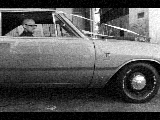

In [22]:
cv2_imshow(inverse_dct_result)

In [23]:
#-------------------------------PSNR------------------------------------------------#
'''
PSNR>30: Compressed image is with high quality
20<PSNR<30: Compressed image is in medium quality
PSNR<20: Compresses image is in low quality

'''

def psnr(original, compressed):
    # Ensure both images have the same shape
    assert original.shape == compressed.shape, "Images must have the same dimensions"

    # Compute Mean Squared Error (MSE)
    mse = np.mean((original - compressed) ** 2)

    # Compute Peak Signal Power (PSP)
    psp = np.max(original) ** 2

    # Compute PSNR
    psnr_value = 10 * np.log10(psp / mse)

    return psnr_value
# Assuming 'original_image' and 'compressed_image' are NumPy arrays
psnr_value = psnr(gray_image, inverse_dct_result)
print(f"PSNR: {psnr_value} dB")


PSNR: 28.918991657749974 dB
